# Advanced Numerical Analysis
## Eigenvalue Problems

### Exercise 1
$(\textrm{i})\quad$ _For which $s\in\mathbb{R}$ do the eigenvalues of the matrix $A=\big(\begin{smallmatrix}1+3s & 4|s| \\ 4|s| & 1−3s \end{smallmatrix}\big)$ depend continuously on $s$? When can the eigenvectors be normalized such that they depend continuously on $s$?_

The solution of $\det(A-\lambda I) = \lambda^2 - \textrm{tr}(A) \lambda + \det(A) = 0$ is $\lambda_{1,2} = 1 \pm 5|s|,$ which is continuous for all $s\in\mathbb{R}.$

If $s\ne0$ then by solving $A \big(\begin{smallmatrix} x \\ y \end{smallmatrix}\big) = \lambda_{1,2}\big(\begin{smallmatrix} x \\ y \end{smallmatrix}\big)$ we obtain the relation $y = \frac{-6\pm10}{8} \frac{s}{|s|} \, x = \begin{cases} \frac{1}{2}\, \textrm{sgn}(s)\, x \\ -2\, \textrm{sgn}(s)\, x \end{cases}.$ Normalizing yields the eigenvectors $\big(\frac{2}{\sqrt{5}},\, \frac{\textrm{sgn}(s)}{\sqrt{5}}\big)^\top$ for $\lambda_1$ and $\big( \frac{1}{\sqrt{5}},\ -\frac{2\,\textrm{sgn}(s)}{\sqrt{5}}\big)^\top$ for $\lambda_2$. Therefore the normalized eigenvectors are discontinuous at $s=0$ but continuous on $\mathbb{R}\setminus\{0\}.$

$(\textrm{ii})\quad$ _What is the appropriate criterion for a general $2\times2$ matrix $A$ depending on $s$?_

Let the entries of $A = \big(\begin{smallmatrix} a & b \\ c & d \end{smallmatrix}\big)$ depend on $s\in\mathbb{C}.$  The eigenvalues of $A$ are $\lambda_{1,2} = \frac{1}{2}\big(a+d\pm\sqrt{D}\big),$ where $D=(a-d)^2+4bc.$ The corresponding normalized eigenvectors are $\big(\sqrt{(d-a\pm\sqrt{D}\,)^2+4b^2}\big)^{-1} \big( \begin{smallmatrix} 2b \\ d-a\pm\sqrt{D} \end{smallmatrix} \big)$ if $b(s)\ne0,\ \Big\{\big(\sqrt{(a-d)^2+c^2}\big)^{-1} \big( \begin{smallmatrix} a-d \\ c \end{smallmatrix} \big),\, \big( \begin{smallmatrix} 0 \\ 1 \end{smallmatrix} \big) \Big\}$ if $b(s)=0$ as well as $c(s)\ne0$ and finally $\big\{ \big( \begin{smallmatrix} 1 \\ 0 \end{smallmatrix} \big),\, \big( \begin{smallmatrix} 0 \\ 1 \end{smallmatrix} \big) \big\}$ if $b(s)=c(s)=0.$

<em style="color:red">Check $b\rightarrow0$ in the first case and $c\rightarrow0$ in the second.</em>

### Exercise 2
_For $n= 2^l$ compare the computation time of the eigenvalues of the $n\times n$ matrix $A$ with entries_

$(\textrm{i})\ \ \quad A_{ik} = i+k$  
$(\textrm{ii})\ \quad A_{ik} = i+k^2$  
$(\textrm{iii}) \quad A_{ik} = \sqrt{ik+i+1}$  
$(\textrm{iv})\: \! \quad A_{ik} = -\max(3-|i-k|,0)$  
$(\textrm{v})\ \: \! \quad A_{ik} = -\max(3-|i-k|,0)$ _in sparse representation_

In [1]:
memory = 4 * 2^30; %bytes
maximum = floor(log2(memory / 8 / 5) / 2); % = 13
clear A

for i = 1:maximum;
    m = 1:2^i;
    
    A{1} = m + m';
    A{2} = m + (m.^2)';
    A{3} = sqrt(m .* m' + m + 1);
    A{4} = -max(3 - abs(m - m'), 0);
    A{5} = sparse(A{4});
    
    for j = 1:5
        tic();
        eig(A{j});
        time(i, j) = toc();
    endfor
endfor

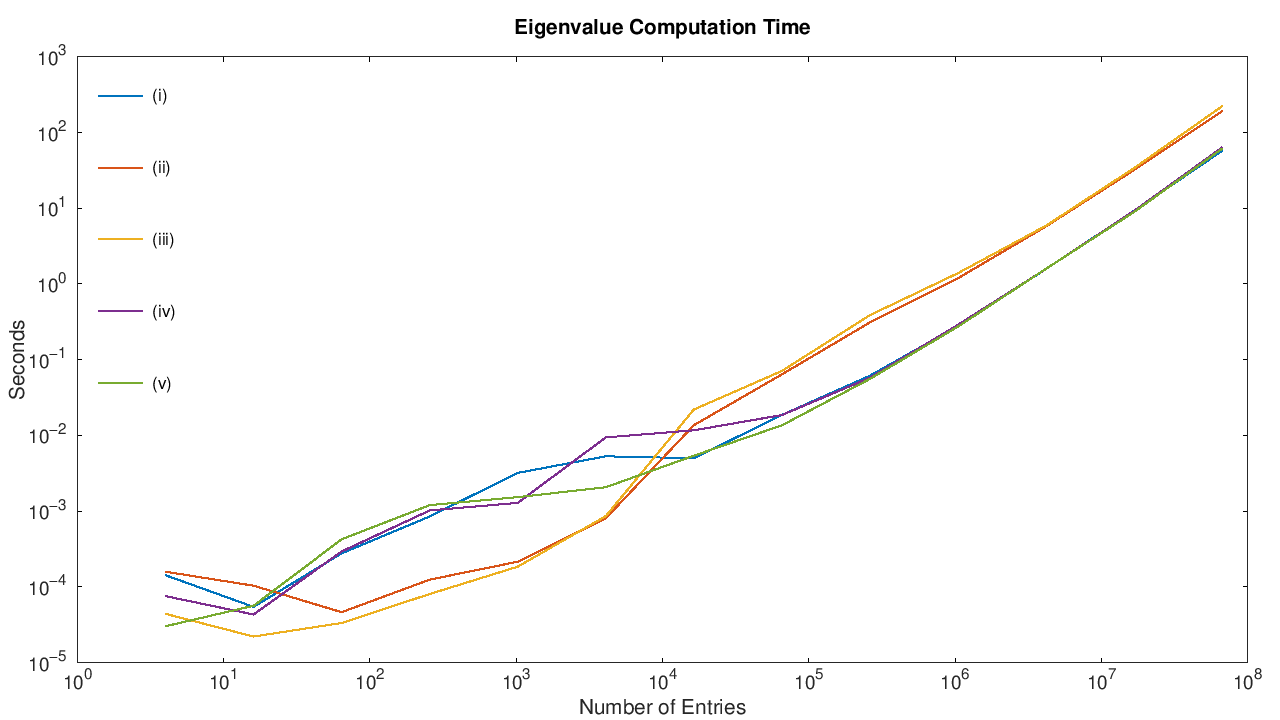

In [3]:
%plot -s 1280,720
x = 2.^[1:maximum].^2;
plt = loglog(x, time);
set(plt, "linewidth", 4);
title("Eigenvalue Computation Time");
xlabel("Number of Entries");
ylabel("Seconds");
legend({"(i)", "(ii)", "(iii)", "(iv)", "(v)"}, "box", "off", "location", "northwest", "fontsize", 9);

For a small number of entries the measurements might not be very reliable. The trend from around $10^5$ onwards may continue because the matrices in $(\textrm{i}), (\textrm{iv})$ and $(\textrm{v})$ are symmetric and Matlab can more efficiently compute eigenvalues from symmetric matrices. It seems that Matlab does not make good use of sparsity.

### Exercise 3


_The reflection $S(u)$ is defined by $S(u):=I-\gamma u u^*$ for $\gamma:=\frac{2}{u^* u},$ where $u\ne0$ is an $n$-dimensional vector._

$(\textrm{i})\quad$ _Give transformation formulae from which, for a given matrix $A\in\mathbb{C}^{n\times n}$ and a vector $u\in\mathbb{C}^n\setminus \{0\}$, the transformed matrix $S(u)AS^{-1}(u)$ may be calculated with the smallest possible computational cost. Count the number of operations which are required, correct to leading order._

Instead of calculating $S(u)$ and doing the matrix multiplications we apply the reflection to each column of $A$ and then to each row of $S(u)A.$ $\gamma$ uses $2n$ operations. Let $x$ be a column vector, then $S(u)x = x - (\gamma u^*x) u$ is $6n$ flops. Similarly for a row vector $y^\top,\ y^\top S(u) = y^\top - (\gamma y^\top u) u^*$ is also $6n$ flops. Applying those to first each column and then to each row of $A$ leaves us with a total of $12n^2$ flops. Just the matrix multiplication of the naive approach would already cost $4n^3-2n^2$ flops.

$(\textrm{ii})\quad$ _Write a program that implements the transformation in $(i)$ for real $A$ and $u.$_

In [4]:
function T = transform(A, u)
    % A: real n by n matrix
    % u: real n-dim. non-zero column vector
    % returns matrix S*A*S for reflection S about hyperplane normal to u
    
    gamma_u = 2 / (u' * u) * u;
    
    % reflection S applied to each column of A
    T = A - gamma_u' * A .* u;
    
    % reflection S applied to each row of S*A
    T = T - T * gamma_u .* u';
    
endfunction

In [5]:
n = 10000;
u = [1:n]';
A = reshape(1:n^2, n, n);

% computation time of transformation formulae
tic()
T1 = transform(A, u);
toc()

% computation time of naive matrix multiplication
tic()
S = eye(n) - 2 / (u' * u) * u * u';
T2 = S*A*S;
toc()

Elapsed time is 1.9736 seconds.
Elapsed time is 47.2583 seconds.


$(\textrm{iii})\quad$ _Use $(\textrm{ii})$ to find a dense $10\times10$ matrix which has the eigenvalues $1,\dots,10.$ Explain why this matrix has the required eigenvalues and check it numerically._

For a matrix $A$ there exists a $u\in\mathbb{R}^n$ such that $R=S(u)AS(u)$ is an upper triangular matrix with its eigenvalues on the diagonal. So conversely by applying the transformation for some $u\in\mathbb{R}^n\setminus\{0\}$ to the diagonal matrix $D=\textrm{diag}(1,\dots,10)$ we get a Hermitian matrix $A$ with eigenvalues $1,\dots,10$ that is probably dense.

In [39]:
n = 10;
u = [1:n]';
D = diag(1:n);
T = transform(D, u)
eigenvalues = eig(T)

T =

 Columns 1 through 7:

   1.071243   0.132096   0.182560   0.222635   0.252319   0.271614   0.280519
   0.132096   2.243414   0.333952   0.403711   0.452690   0.480891   0.488312
   0.182560   0.333952   3.454174   0.543228   0.601113   0.627829   0.623377
   0.222635   0.403711   0.543228   4.641187   0.697588   0.712430   0.685714
   0.252319   0.452690   0.601113   0.697588   5.742115   0.734694   0.675325
   0.271614   0.480891   0.627829   0.712430   0.734694   6.694620   0.592208
   0.280519   0.488312   0.623377   0.685714   0.675325   0.592208   7.436364
   0.279035   0.474954   0.587755   0.617440   0.564007   0.427458   0.207792
   0.267161   0.440816   0.520965   0.507607   0.400742   0.200371  -0.093506
   0.244898   0.385900   0.423006   0.356215   0.185529  -0.089054  -0.467532

 Columns 8 through 10:

   0.279035   0.267161   0.244898
   0.474954   0.440816   0.385900
   0.587755   0.520965   0.423006
   0.617440   0.507607   0.356215
   0.564007   0.400742   0.1855

### Exercise 5

_Consider the block diagonal matrix_ $A = \big(\begin{smallmatrix} A_1 & 0 \\ 0 & A_2 \end{smallmatrix}\big).$ _Suppose that_ $A_i$ _has a spectral factorization_ $A_i = S_i \Lambda_i S_i^{-1}$ for $i= 1,2.$

$(\textrm{i})\quad$ _What is the spectral factorization of $A$?_

Let $\Lambda = \big(\begin{smallmatrix} \Lambda_1 & 0 \\ 0 & \Lambda_2 \end{smallmatrix}\big)$ and $S=\big(\begin{smallmatrix} S_1 & 0 \\ 0 & S_2 \end{smallmatrix}\big).$ Then $S$ is unitary since $S^* = \big(\begin{smallmatrix} S_1^* & 0 \\ 0 & S_2^* \end{smallmatrix}\big) = \big(\begin{smallmatrix} S_1^{-1} & 0 \\ 0 & S_2^{-1} \end{smallmatrix}\big) = S^{-1}.$ Therefore the spectral factorization of $A$ is $S\Lambda S^{-1} = \big(\begin{smallmatrix} S_1 & 0 \\ 0 & S_2 \end{smallmatrix}\big) \big(\begin{smallmatrix} \Lambda_1 & 0 \\ 0 & \Lambda_2 \end{smallmatrix}\big) \big(\begin{smallmatrix} S_1^{-1} & 0 \\ 0 & S_2^{-1} \end{smallmatrix}\big) = \big(\begin{smallmatrix} S_1\Lambda_1 S_1^{-1} & 0 \\ 0 & S_2\Lambda_2 S_2^{-1} \end{smallmatrix}\big) = \big(\begin{smallmatrix} A_1 & 0 \\ 0 & A_2 \end{smallmatrix}\big) = A.$

$(\textrm{ii})\quad$ _Suppose_ $\lambda$ _is an eigenvalue of_ $A_1$ _and_ $A_2.$ _Describe the eigenvectors of $A$ belonging to_ $\lambda.$

If $A \big(\begin{smallmatrix} v_1 \\ v_2 \end{smallmatrix}\big) = \big(\begin{smallmatrix} A_1 v_1 \\ A_2 v_2 \end{smallmatrix}\big) = \big(\begin{smallmatrix} \lambda v_1 \\ \lambda v_2 \end{smallmatrix}\big)$ then $v_1$ and $v_2$ must be in the respective eigenspaces of $A_1$ and $A_2$ corresponding to $\lambda.$ Therefore $v = \big(\begin{smallmatrix} v_1 \\ v_2 \end{smallmatrix}\big)$ is an eigenvector of $A$ corresponding to $\lambda$ if and only if either both $v_1$ and $v_2$ are respective eigenvectors or just one is an eigenvector and the other the zero vector.

$(\textrm{iii})\quad$ _Answer the corresponding questions for_ $A = \big(\begin{smallmatrix} A_{11} & A_{12} \\ 0 & A_{22} \end{smallmatrix}\big)$ _and the Schur decomposition of_ $A.$

- Let $A_{ii} = Q_{ii} R_{ii} Q_{ii}^*$ for unitary matrices $Q_{ii}$ and upper triangular matrices $R_{ii},\ i=1,2$ and $Q = \big(\begin{smallmatrix} Q_{11} & 0 \\ 0 & Q_{22} \end{smallmatrix}\big),\ R = \big(\begin{smallmatrix} R_{11} & Q_{11}^* A_{12} Q_{22} \\ 0 & R_{22} \end{smallmatrix}\big).$ Then $Q$ is unitary, $R$ is an upper triangular matrix and the Schur decomposition of $A$ is $QRQ^* = \big(\begin{smallmatrix} Q_{11} R_{11} Q_{11}^* & Q_{11} Q_{11}^* A_{12} Q_{22} Q_{22}^* \\ 0 & Q_{22} R_{22} Q_{22}^* \end{smallmatrix}\big) = A.$


- Let $\lambda$ be an eigenvalue of $A_{11}$ and $A_{22.}$ From $A \big(\begin{smallmatrix} v_1 \\ v_2 \end{smallmatrix}\big) = \big(\begin{smallmatrix} A_{11} v_1 + A_{12} v_2 \\ A_2 v_2 \end{smallmatrix}\big) = \big(\begin{smallmatrix} \lambda v_1 \\ \lambda v_2 \end{smallmatrix}\big)$ follows that $v = \big(\begin{smallmatrix} v_1 \\ v_2 \end{smallmatrix}\big)$ is an eigenvector of $A$ corresponding to $\lambda$ if $v_1$ is an eigenvector of $A_{11}$ and $v_2\in\textrm{ker}(A_{12})\cap \textrm{E}(A_{22},\lambda)$ or if $v_1$ is an eigenvector of $A_{22}$ and $v_2 = A_{12}^{-1}(\lambda I - A_{11})v_1,$ where $\textrm{E}(A_{22},\lambda)$ denotes the eigenspace of $A_{22}$ for the eigenvalue $\lambda.$

### Exercise 8

_The spectral radius of_ $A\in\mathbb{C}^{n \times n}$ _is defined as_ $\rho(A) := {\displaystyle \max_{i=1:n}} \ |\lambda_i|,$ _where_ $\lambda_i$ _are the eigenvalues of $A.$ Show:_

$(\textrm{i})\quad$ _For each matrix norm_ $\rho(A) \le |\!|A|\!|.$

Let $\lambda$ be an eigenvalue of $A$ with corresponding eigenvector $v$ and let $|\!|\cdot|\!|$ be a sub-multiplicative matrix norm. Then $|\lambda||\!|v|\!| = |\!|\lambda v|\!| = |\!|Av|\!| \le |\!|A|\!||\!|v|\!|$ and since $v\ne0$ it follows that $|\lambda| \le |\!|A|\!|$ for all eigenvalues $\lambda$ of $A.$ Therefore $\rho(A)\le |\!|A|\!|.$

$(\textrm{ii})\quad$ _If $A$ is Hermitian then_ $\rho(A) = |\!|A|\!|_2.$

Since $A$ is Hermitian there exists a spectral decomposition $A = Q \Lambda Q^{-1}$ with unitary matrix $Q$ and diagonal eigenvalue matrix $\Lambda.$ Because of $(\textrm{i})$ it suffices to show that $|\!|A|\!|_2 \le \rho(A).$
$$|\!|A|\!|_2 = |\!|Q \Lambda Q^{-1}|\!|_2 \le |\!|Q|\!|_2 |\!|\Lambda|\!|_2 |\!|Q^{-1}|\!|_2 = |\!|\Lambda|\!|_2 = \sup_{|\!|x|\!|_2 = 1} |\!|\Lambda x|\!|_2 = \sup_{|\!|x|\!|_2 = 1} \sqrt{\sum_{i=1}^n |\lambda_i x_i|^2} \le \sup_{|\!|x|\!|_2 = 1} \rho(A) \sqrt{\sum_{i=1}^n |x_i|^2} = \rho(A) \sup_{|\!|x|\!|_2 = 1} |\!|x|\!|_2 = \rho(A)$$

### Exercise 10
_Show that the zeros of a polynomial $p(x)$ represented in a Chebyshev basis as_ $p(x) = \sum_{i=0}^n a_i T_i(x),$ _where_ $a_n \ne 0.,$ _are precisely the halved eigenvalues of the lower Hessenberg matrix_

$$ A =
\begin{pmatrix}
0 & 2 & 0 & \cdots & \cdots & 0\\
1 & 0 & 1 & \ddots & & \vdots \\
0 & 1 & 0 & 1 & \ddots & \vdots \\
\vdots & & \ddots & \ddots & \ddots & 0 \\
0 & \cdots & 0 & 1 & 0 & 1 \\
b_1 & \cdots & \cdots & \cdots & \cdots & b_n
\end{pmatrix},$$

_where_ $b_i = −\frac{a_{i−1}}{a_n}$ _for_ $i\ne n-1$ _and_ $b_{n−1} = 1 − \frac{a_{n−2}}{a_n}.$

Let $\lambda$ be an eigenvalue of $A$ and $v$ a corresponding eigenvector. Then $\lambda v_1 = (Av)_1 = 2v_2,\ \lambda v_i = (Av)_i = v_{i-1} + v_{i+1}$ for $i=2,\dots,n-1$ and $\lambda v_n = (Av)_n = \sum_{j=1}^n b_j v_j.$ Also $v_1$ cannot be zero since otherwise $v$ would be the zero vector and not an eigenvector because $v_2 = \frac{\lambda}{2} v_1 = 0$ and $v_{i+1} = \lambda v_i - v_{i-1} = 0$ for all $i=3,\dots,n.$

The recurrence relations of the Chebyshev polynomials is $\begin{cases} T_{i+1}(x) = 2xT_i(x)-T_{i-1}(x) \\ T_0(x) = 1,\ T_1(x) = x \end{cases}.$

$T_1\big(\frac{\lambda}{2}\big)v_1 = \big(\frac{\lambda}{2}\big) v_1 = v_2$ is our base case.

$i\rightarrow i+1:\quad T_i\big(\frac{\lambda}{2}\big) v_1 = \big(\lambda T_{i-1}\big(\frac{\lambda}{2}\big) - T_{i-2}\big(\frac{\lambda}{2}\big)\big) v_1 = \lambda v_i - v_{i-1} = v_{i+1}$

Thus we have $v_i = T_{i-1}\big(\frac{\lambda}{2}\big) v_1$ for $i=2,\dots,n.$ Substituting this relation into the equation for $v_n$ yields

$$\begin{align*}
0 &= \lambda z_n - \sum_{j=1}^n b_j v_j = - b_1 v_1 - \sum_{j=2}^{n-2} b_j T_{j-1}\big(\frac{\lambda}{2}\big) v_1 - b_{n-1} T_{n-2}\big(\frac{\lambda}{2}\big) v_1 + (\lambda - b_n) T_{n-1}\big(\frac{\lambda}{2}\big) v_1 \\
&= \frac{a_0}{a_n} T_0\big(\frac{\lambda}{2}\big) + \sum_{j=2}^{n-2} \frac{a_{j-1}}{a_n} T_{j-1}\big(\frac{\lambda}{2}\big) + \big(\frac{a_{n-2}}{a_n} - 1\big) T_{n-2}\big(\frac{\lambda}{2}\big) + \big(\frac{a_{n-1}}{a_n} + \lambda a_n\big) T_{n-1}\big(\frac{\lambda}{2}\big) \\
&= \sum_{j=0}^{n-3} a_j T_j\big(\frac{\lambda}{2}\big) + a_{n-2} T_{n-2}\big(\frac{\lambda}{2}\big) + a_{n-1} T_{n-1}\big(\frac{\lambda}{2}\big) + a_n \big(\lambda T_{n-1}\big(\frac{\lambda}{2}\big) - T_{n-2}\big(\frac{\lambda}{2}\big)\big) \\
&= \sum_{j=0}^n a_j T_j\big(\frac{\lambda}{2}\big) \\
&= p\big(\frac{\lambda}{2}\big).
\end{align*}$$

Therefore $\frac{\lambda}{2}$ is a zero of $p.$